# Image Warping Lab

## Part 1: Interpolation

Since we are going to be warping images, we need to make sure we have a good interpolation function to deal with inexact pixel locations.

In the cell below, we want to scale an image by a factor of 2.30 in both x and y. **Write a function called "interpolate" that performs bilinear interpolation.** This function should take in the image and a location (x,y) of interest. It then uses the nearby pixels to that location to interpolate and return an RGB value.

**Note:** For this lab, we will keep images as floats to simplify the interpolation. Thus, output your images as values between 0-1, not 0-255.

0.99215686


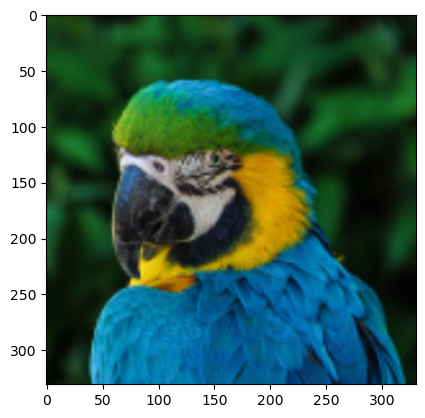

In [68]:
import matplotlib.pyplot as plt
import numpy as np

#Your bilinear interpolation function
def interpolate(image, x, y):
    
    # Get the dimensions of the input image
    h, w, _ = image.shape
    
    # Calculate the coordinates of the four nearest pixels
    x1, y1 = int(np.floor(x)), int(np.floor(y))
    x2, y2 = min(x1 + 1, w - 1), min(y1 + 1, h - 1)
    
    # Calculate the fractional parts for interpolation
    dx, dy = x - x1, y - y1
    
    # Perform bilinear interpolation
    top_left = image[y1, x1]
    top_right = image[y1, x2]
    bottom_left = image[y2, x1]
    bottom_right = image[y2, x2]
    
    interpolated_value = (1 - dx) * (1 - dy) * top_left + dx * (1 - dy) * top_right + \
                         (1 - dx) * dy * bottom_left + dx * dy * bottom_right
    
    return interpolated_value



filename = "test.png"
im = plt.imread(filename)

print(np.amax(im)) #Image values should be between 0-1, not 0-255

h,w,_ = im.shape

result = np.zeros((int(2.3*h),(int(2.3*w)),3), dtype="float32")

rows, cols, _ = result.shape

# Map each new point back to the original image
for i in range(rows):
    for j in range(cols):
        result[i,j] = interpolate(im, j/2.3, i/2.3)

        
plt.imshow(result,vmin=0)
plt.show()

## Part 2: Backwards Mapping

Now that we have a interpolation function,**write a function that performs a backwards mapping. This function should also call your interpolate function.**

For this example, a simple rotation transformation will be given. Your function should take each pixel/point, turn it into a homogenous coordinate, multiply it by the inverted transformation, and write the interpolated value from the source_im. **Don't forget to invert the transform. This is really easy if you use the numpy linalg library.**

The source and target image will be the same size, which means part of your rotated image will be cut off on the corners. You can assume that all pixels need to be backward mapped. Any pixel/point that maps to a point outside the image boundaries should be skipped. **Don't forget the homogenous divide as well.**

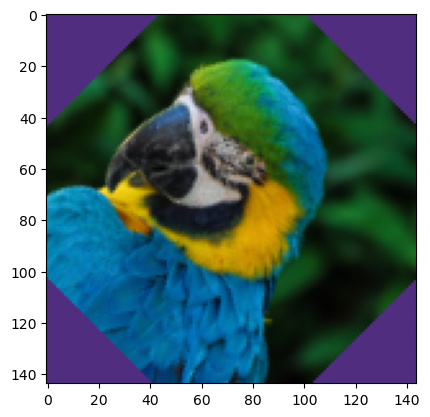

In [69]:
def backmap(source_im,target_im,transform):
    
    hs,ws,_ = source_im.shape
    ht,wt,_ = target_im.shape
    result = np.copy(target_im)
    
    # Invert the transformation matrix
    inverted_transform = np.linalg.inv(transform)
    
    for i in range(ht):
        for j in range(wt):
            # Create a homogeneous coordinate [x, y, 1]
            homogenous_coord = np.array([[j, i, 1]])
            
            # Apply the inverse transformation
            source_coord = np.dot(inverted_transform, homogenous_coord.T)
            
            # Dehomogenize the coordinate
            source_coord = source_coord[:2] / source_coord[2]
            
            x, y = source_coord[0, 0], source_coord[1, 0]
            
            # Check if the mapped point is within the source image boundaries
            if 0 <= x < ws and 0 <= y < hs:
                # Interpolate the pixel value using bilinear interpolation
                result[i, j] = interpolate(source_im, x, y)
    
    
    return result


from math import sin,cos,pi

filename = "test.png"
im = plt.imread(filename)
canvas = np.zeros_like(im) + np.array([[[80/255,45/255,127/255]]]) #ECU Purple

transform = np.matrix([[cos(45 * pi/180), -sin(45 * pi/180), w/2],[sin(45 * pi/180),cos(45 * pi/180),-h/5],[0,0,1]])

result = backmap(im,canvas,transform)

plt.imshow(result,vmin=0)
plt.show()


## Part 3: Perspective Warp

Now that we have the two specific functions that we need, let's start looking at some more interesting image warping. In class, we discussed how we can use homographies to perform perspective warps. In this lab, we have provided the homography generating code for you. 

In [70]:
class Point():
    def __init__(self,x,y):
        self.x = x
        self.y = y


def getHomography(s0,s1,s2,s3,t0,t1,t2,t3):

    x0s = s0.x
    y0s = s0.y
    x0t = t0.x
    y0t = t0.y

    x1s = s1.x
    y1s = s1.y
    x1t = t1.x
    y1t = t1.y

    x2s = s2.x
    y2s = s2.y
    x2t = t2.x
    y2t = t2.y

    x3s = s3.x
    y3s = s3.y
    x3t = t3.x
    y3t = t3.y

    #Solve for the homography matrix
    A = np.matrix([
            [x0s, y0s, 1, 0, 0, 0, -x0t*x0s, -x0t*y0s],
            [0, 0, 0, x0s, y0s, 1, -y0t*x0s, -y0t*y0s],
            [x1s, y1s, 1, 0, 0, 0, -x1t*x1s, -x1t*y1s],
            [0, 0, 0, x1s, y1s, 1, -y1t*x1s, -y1t*y1s],
            [x2s, y2s, 1, 0, 0, 0, -x2t*x2s, -x2t*y2s],
            [0, 0, 0, x2s, y2s, 1, -y2t*x2s, -y2t*y2s],
            [x3s, y3s, 1, 0, 0, 0, -x3t*x3s, -x3t*y3s],
            [0, 0, 0, x3s, y3s, 1, -y3t*x3s, -y3t*y3s]
        ])

    b = np.matrix([
            [x0t],
            [y0t],
            [x1t],
            [y1t],
            [x2t],
            [y2t],
            [x3t],
            [y3t]
        ])

    #The homorgraphy solutions a-h
    solutions = np.linalg.solve(A,b)

    solutions = np.append(solutions,[[1.0]], axis=0)

    #Reshape the homography into the appropriate 3x3 matrix
    homography = np.reshape(solutions, (3,3))
    
    return homography

We want to be able to get a new image into the TV set in the image shown below. 

To place the bird correctly inside the TV, do the following:

1. Determine the homography that maps from the bird image to the TV. Use the `getHomography` function and the provided points.

2. For each pixel/point within the target image, backmap those points on to bird image. Use your `backmap` function and make sure it correctly rejects points that do not land within the image boundary

Write a general perspective warp function that completes these steps. **Hint: If your backmap function is written correctly, this should only be 2-3 lines of code.**

[[8.71281607e-01 2.36947519e-02 2.45000000e+02]
 [4.79089202e-02 7.79957906e-01 1.52000000e+02]
 [4.12632894e-04 6.78932718e-05 1.00000000e+00]]


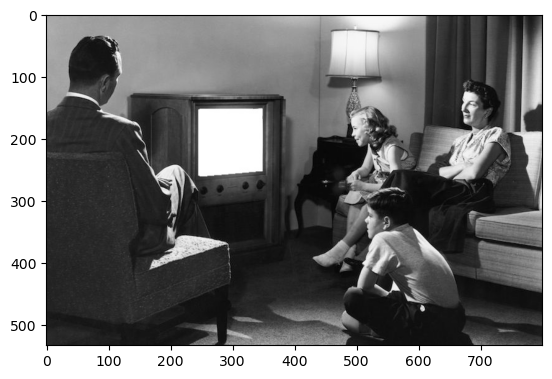

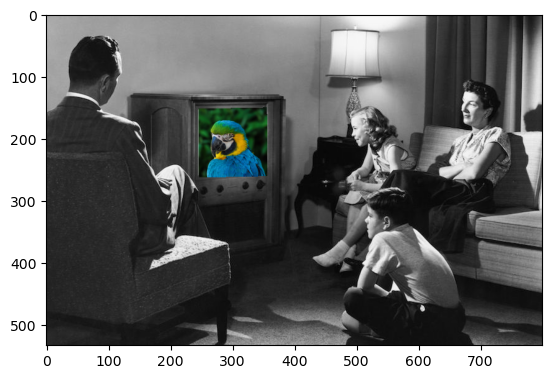

In [71]:
def perspectiveWarp(source_im,target_im,s0,s1,s2,s3,t0,t1,t2,t3):
    
    result = np.copy(target_im)
    
    ht, wt, _ = target_im.shape

    # Calculate the homography matrix
    homography_matrix = getHomography(s0, s1, s2, s3, t0, t1, t2, t3)

    # Iterate through the pixels in the target image
    for i in range(ht):
        for j in range(wt):
            # Apply the inverse homography to map target image coordinates to source image
#             x, y, z = np.dot(np.linalg.inv(homography_matrix), np.array([j, i, 1]))              
#             x /= z
#             y /= z
            
            p = np.array([[j],
                        [i],
                        [1]])

            new_p = np.matmul(np.linalg.inv(homography_matrix),p)

            x = new_p[0,0]

            y = new_p[1,0]

            z = new_p[2,0]
            


            # Check if the mapped coordinates are within the source image boundaries
            if 0 <= x < source_im.shape[1] and 0 <= y < source_im.shape[0]:
                # Interpolate the pixel value using bilinear interpolation
                interpolated_value = interpolate(source_im, x, y)
                result[i, j] = interpolated_value


    return result
    

filename = "test.png"
im = plt.imread(filename)

h,w,_ = im.shape
        
s0 = Point(0,0)
s1 = Point(w-1,0)
s2 = Point(w-1,h-1)
s3 = Point(0,h-1)

t0 = Point(245,152)
t1 = Point(349,150)
t2 = Point(349,253)
t3 = Point(246,261)

print(getHomography(s0,s1,s2,s3,t0,t1,t2,t3))
# print(p.shape)
# print(new_p.shape)
# print(matrix.shape)

tv = plt.imread('tv.png')
plt.imshow(tv,vmin=0)
plt.show()

result = perspectiveWarp(im,tv,s0,s1,s2,s3,t0,t1,t2,t3)

plt.imshow(result,vmin=0)
plt.show()


# Part 4: Speed Up

We have a complete perspective warping algorithm now, but you may have noticed that it runs a little slowly. This is because it checks every pixel in the target image to see if it needs to be backmapped. A much faster solution is create a min-max bounding box around the warping points and only checking pixels within that bounding box. **See the bounding box example image provided with the lab.**

For this last part of the lab, rewrite your perspective warp and backmapping functions as needed so that they only check pixels in the relevant bounding box in the image. Compare the run times between the previous approach and your new method. You may find `np.amax()` and `np.amin()` to be helpful.

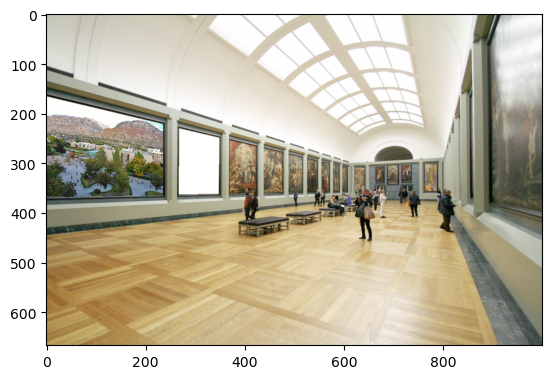

Slow Method: 9.638948202133179


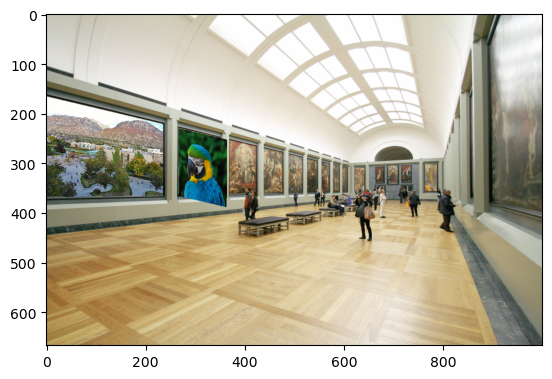

Fast Method: 0.2943148612976074


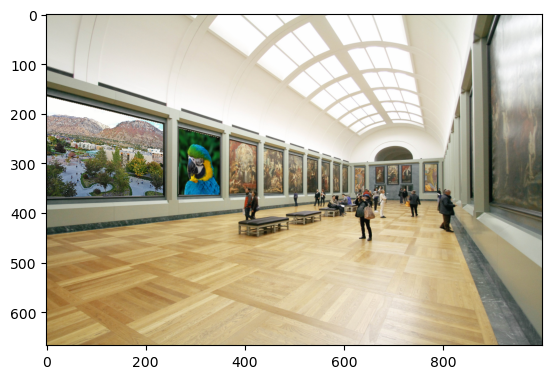

In [82]:
#def backmapFast(Whatever inputs you may need):   
#    return None


def perspectiveWarpFast(source_im,target_im,s0,s1,s2,s3,t0,t1,t2,t3):
    
    result = np.copy(target_im)
    
    # Calculate the bounding box
    x_min = int(np.amin([t0.x, t1.x, t2.x, t3.x]))
    x_max = int(np.amax([t0.x, t1.x, t2.x, t3.x]))
    y_min = int(np.amin([t0.y, t1.y, t2.y, t3.y]))
    y_max = int(np.amax([t0.y, t1.y, t2.y, t3.y]))

    ht, wt, _ = target_im.shape

    # Calculate the homography matrix
    homography_matrix = getHomography(s0, s1, s2, s3, t0, t1, t2, t3)
    
    # Iterate through the pixels only within the bounding box
    for i in range(y_min, y_max+1):
        for j in range(x_min, x_max+1):
            # Apply the inverse homography to map target image coordinates to source image
#             x, y, z = np.dot(np.linalg.inv(homography_matrix), np.array([j, i, 1]))
#             x /= z
#             y /= z

            p = np.array([[j],
                        [i],
                        [1]])

            new_p = np.matmul(np.linalg.inv(homography_matrix),p)

            x = new_p[0,0]

            y = new_p[1,0]

            z = new_p[2,0]
            

            # Check if the mapped coordinates are within the source image boundaries
            if 0 <= x < source_im.shape[1] and 0 <= y < source_im.shape[0]:
                # Interpolate the pixel value using bilinear interpolation
                interpolated_value = interpolate(source_im, x, y)
                result[i, j] = interpolated_value
    
    return result
    

from time import time
    
museum = plt.imread('museum.png')
plt.imshow(museum,vmin=0)
plt.show()

filename = "test.png"
im = plt.imread(filename)

h,w,_ = im.shape
        
s0 = Point(0,0)
s1 = Point(w-1,0)
s2 = Point(w-1,h-1)
s3 = Point(0,h-1)

t0 = Point(268,230)
t1 = Point(349,249)
t2 = Point(347,361)
t3 = Point(267,363)

#Points for nearest canvas
#t0 = Point(0,170)
#t1 = Point(235,222)
#t2 = Point(236,365)
#t3 = Point(0,368)


start = time()
result1 = perspectiveWarp(im,museum,s0,s1,s2,s3,t0,t1,t2,t3)
print("Slow Method:",time()-start)

plt.imshow(result1,vmin=0)
plt.show()

start = time()
result2 = perspectiveWarpFast(im,museum,s0,s1,s2,s3,t0,t1,t2,t3)
print("Fast Method:",time()-start)

#plt.imsave("Output.png",result2)
plt.imshow(result2,vmin=0)
plt.show()